# Blacklist rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Number of 'things'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("webrequest")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][2].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
things

{'DESKTOP-PIMD8C0': {'0.gravatar.com',
  '0012f4-1.l.windowsupdate.com',
  '001beb-1.l.windowsupdate.com',
  '00251e-1.l.windowsupdate.com',
  '11.dl.delivery.mp.microsoft.com',
  '11.tlu.dl.delivery.mp.microsoft.com',
  '1a.dl.delivery.mp.microsoft.com',
  '1a.tlu.dl.delivery.mp.microsoft.com',
  '2.gravatar.com',
  '3.au.download.windowsupdate.com',
  '3.bp.blogspot.com',
  '3.dl.delivery.mp.microsoft.com',
  '3.tlu.dl.delivery.mp.microsoft.com',
  '4.au.download.windowsupdate.com',
  '4.bp.blogspot.com',
  '4.dl.delivery.mp.microsoft.com',
  '4.tlu.dl.delivery.mp.microsoft.com',
  '7.au.download.windowsupdate.com',
  '7.dl.delivery.mp.microsoft.com',
  '7.tlu.dl.delivery.mp.microsoft.com',
  '9.au.download.windowsupdate.com',
  '9.dl.delivery.mp.microsoft.com',
  '9.tlu.dl.delivery.mp.microsoft.com',
  'a.clickcertain.com',
  'a.tribalfusion.com',
  'aa.agkn.com',
  'aax.amazon-adsystem.com',
  'acdn.adnxs.com',
  'acuityplatform.com',
  'ad.afy11.net',
  'ad.crwdcntrl.net',
  'ad.t

In [6]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct user agent to device matrix

In [7]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,languid-mac,minesweepers-mac,essential-cb,daniel-chromebook,elysium-mac,tirasse-mac,DESKTOP-PIMD8C0,turing-chromebook,calcannea-mac,dgmac,...,theatergoing-mac,dramatic-mac,terrestrial-mac,steamverne-mac,calcannea-cb,rarb-mac,turing-minimacbook,misskitty-mac,serotinal-mac,score
speedtestuk1.cybersmart.co.za:8080,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,2
8208101.fls.doubleclick.net,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
audex.userreport.com,0,0,0,0,0,0,0,0,0,0,...,0,0,7,0,0,0,0,0,0,8
bevo-us-east-1.adsnative.com,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,3
mobaxterm.mobatek.net,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
cj.dotomi.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,3
fastermac.tech,0,0,0,0,0,0,0,0,0,0,...,0,12,0,0,0,0,0,0,0,12
amd.cedexis-test.com,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,4
apex.go.sonobi.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,10
www.layerthemes.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0,9


## Get list of highest accessed user agents by all devices

In [8]:
top_things = df.sort_values(by="score", ascending=False).index.values[:n]
top_things

array(['asset-cdn.glb.agni.lindenlab.com', 'assetgame.roblox.com',
       '35.190.145.159:8081', ...,
       '5io0615vq7k4e1k1l12k8b3r.wpengine.netdna-cdn.com',
       'i2-swhgizqquqmodzipknihngmxpnfzbo.init.cedexis-radar.net',
       'i2-kmjqcdllvxinshgzhpbzckgmpscahc.init.cedexis-radar.net'],
      dtype=object)

## Spearman's Rho

In [9]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourites by device

In [10]:
fav_things = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_things

[['languid-mac',
  array(['www.loopnet.com', 'ocsp.digicert.com', 'images2.loopnet.com', ...,
         'c-7npsfqifvt34x24qjyfmx2eubqbex2edpn.g00.metrolyrics.com',
         'adscale.de', 'cdn.appexnw.com'], dtype=object)],
 ['minesweepers-mac',
  array(['eu-rseg-tts.inrix.com', 'cdn.clamxav.com', 'www.woopra.com', ...,
         'incluster.com', 'thedevilspanties.com', 'cdn.appexnw.com'],
        dtype=object)],
 ['essential-cb',
  array(['www.gstatic.com', 'www.douglasadams.com', 'thedevilspanties.com',
         ..., 'ad.360yield.com', 'consent.trustarc.com', 'cdn.appexnw.com'],
        dtype=object)],
 ['daniel-chromebook',
  array(['ecx.images-amazon.com', 'www.com', 'et1.getsidekick.com', ...,
         'c-7npsfqifvt34x24nusyx2ehpx2etpopcjx2edpn.g00.metrolyrics.com',
         't6.rbxcdn.com', 'cdn.appexnw.com'], dtype=object)],
 ['elysium-mac', array(['ocsp.digicert.com', 'www.blackrainbow.com',
         'ocsp.int-x3.letsencrypt.org', ..., 'cert.int-x3.letsencrypt.org',
         'www.

In [11]:
df2 = pd.DataFrame(fav_things, columns=["device", "servers"]).set_index("device")
df2

,servers
device,
languid-mac,"[www.loopnet.com, ocsp.digicert.com, images2.l..."
minesweepers-mac,"[eu-rseg-tts.inrix.com, cdn.clamxav.com, www.w..."
essential-cb,"[www.gstatic.com, www.douglasadams.com, thedev..."
daniel-chromebook,"[ecx.images-amazon.com, www.com, et1.getsideki..."
elysium-mac,"[ocsp.digicert.com, www.blackrainbow.com, ocsp..."
tirasse-mac,"[analytics.carambo.la, aldertons.com, www.cock..."
DESKTOP-PIMD8C0,"[3.tlu.dl.delivery.mp.microsoft.com, 11.tlu.dl..."
turing-chromebook,"[www.gstatic.com, mmcc.maryland.gov, ocsp.como..."
calcannea-mac,"[m.bbc.co.uk, www.bbc.co.uk, nginx.org, www.gs..."


## Compute Spearman co-efficient
against most common domains

In [12]:
df2["coefficient"] = df2["servers"].apply(lambda x: spearman(x, top_things)).round(2)

In [13]:
df2.sort_values(by="coefficient", ascending=False)[["servers", "coefficient"]]

,servers,coefficient
device,,
misskitty-mac,"[asset-cdn.glb.agni.lindenlab.com, r059.digiwo...",0.15
steamverne-mac,"[ocsp.digicert.com, ib.adnxs.com, gb.archive.u...",0.15
DESKTOP-PIMD8C0,"[3.tlu.dl.delivery.mp.microsoft.com, 11.tlu.dl...",0.14
LAPTOP-1I501C4U,"[3.tlu.dl.delivery.mp.microsoft.com, 11.tlu.dl...",0.14
boundless-mac,"[35.190.145.159:8081, 35.190.145.159:8080, ocs...",0.13
mark-mac,"[fedoraproject.org, www.phonetipsandtricks.com...",0.12
terrestrial-mac,"[ads.adaptv.advertising.com, acds.prod.vidible...",0.12
dramatic-mac,"[assetgame.roblox.com, heartbeat.dm.origin.com...",0.12
languid-mac,"[www.loopnet.com, ocsp.digicert.com, images2.l...",0.12


## Device to device co-efficient

In [14]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_things, columns=["device", "servers"]).set_index("device")
for dev, bls in everyone:
    df3[dev] = df3["servers"].apply(lambda x: spearman(bls, x)).round(2)

In [15]:
df3

,servers,languid-mac,minesweepers-mac,essential-cb,daniel-chromebook,elysium-mac,tirasse-mac,DESKTOP-PIMD8C0,turing-chromebook,calcannea-mac,...,nervings-cb,theatergoing-mac,dramatic-mac,terrestrial-mac,steamverne-mac,calcannea-cb,rarb-mac,turing-minimacbook,misskitty-mac,serotinal-mac
device,,,,,,,,,,,,,,,,,,,,,
languid-mac,"[www.loopnet.com, ocsp.digicert.com, images2.l...",1.00,0.67,0.70,0.71,0.70,0.70,0.73,0.71,0.71,...,0.71,0.71,0.20,0.61,0.68,0.71,0.71,0.70,0.55,0.69
minesweepers-mac,"[eu-rseg-tts.inrix.com, cdn.clamxav.com, www.w...",0.67,1.00,0.79,0.81,0.71,0.82,0.75,0.81,0.82,...,0.83,0.83,0.24,0.56,0.71,0.82,0.82,0.80,0.58,0.73
essential-cb,"[www.gstatic.com, www.douglasadams.com, thedev...",0.70,0.79,1.00,0.86,0.72,0.85,0.79,0.85,0.86,...,0.86,0.85,0.25,0.57,0.69,0.85,0.86,0.83,0.55,0.72
daniel-chromebook,"[ecx.images-amazon.com, www.com, et1.getsideki...",0.71,0.81,0.86,1.00,0.73,0.90,0.81,0.97,0.99,...,0.96,0.94,0.32,0.58,0.71,0.95,0.98,0.90,0.57,0.74
elysium-mac,"[ocsp.digicert.com, www.blackrainbow.com, ocsp...",0.70,0.71,0.72,0.73,1.00,0.72,0.73,0.73,0.73,...,0.73,0.73,0.21,0.58,0.71,0.73,0.74,0.72,0.56,0.70
tirasse-mac,"[analytics.carambo.la, aldertons.com, www.cock...",0.70,0.82,0.85,0.90,0.72,1.00,0.79,0.90,0.90,...,0.91,0.90,0.28,0.59,0.73,0.90,0.90,0.88,0.59,0.74
DESKTOP-PIMD8C0,"[3.tlu.dl.delivery.mp.microsoft.com, 11.tlu.dl...",0.73,0.75,0.79,0.81,0.73,0.79,1.00,0.81,0.81,...,0.81,0.81,0.24,0.60,0.70,0.80,0.81,0.79,0.56,0.70
turing-chromebook,"[www.gstatic.com, mmcc.maryland.gov, ocsp.como...",0.71,0.81,0.85,0.97,0.73,0.90,0.81,1.00,0.97,...,0.95,0.94,0.31,0.58,0.71,0.94,0.97,0.91,0.57,0.74
calcannea-mac,"[m.bbc.co.uk, www.bbc.co.uk, nginx.org, www.gs...",0.71,0.82,0.86,0.99,0.73,0.90,0.81,0.97,1.00,...,0.96,0.94,0.31,0.58,0.71,0.95,0.98,0.90,0.57,0.74


## Plot heatmap

In [16]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

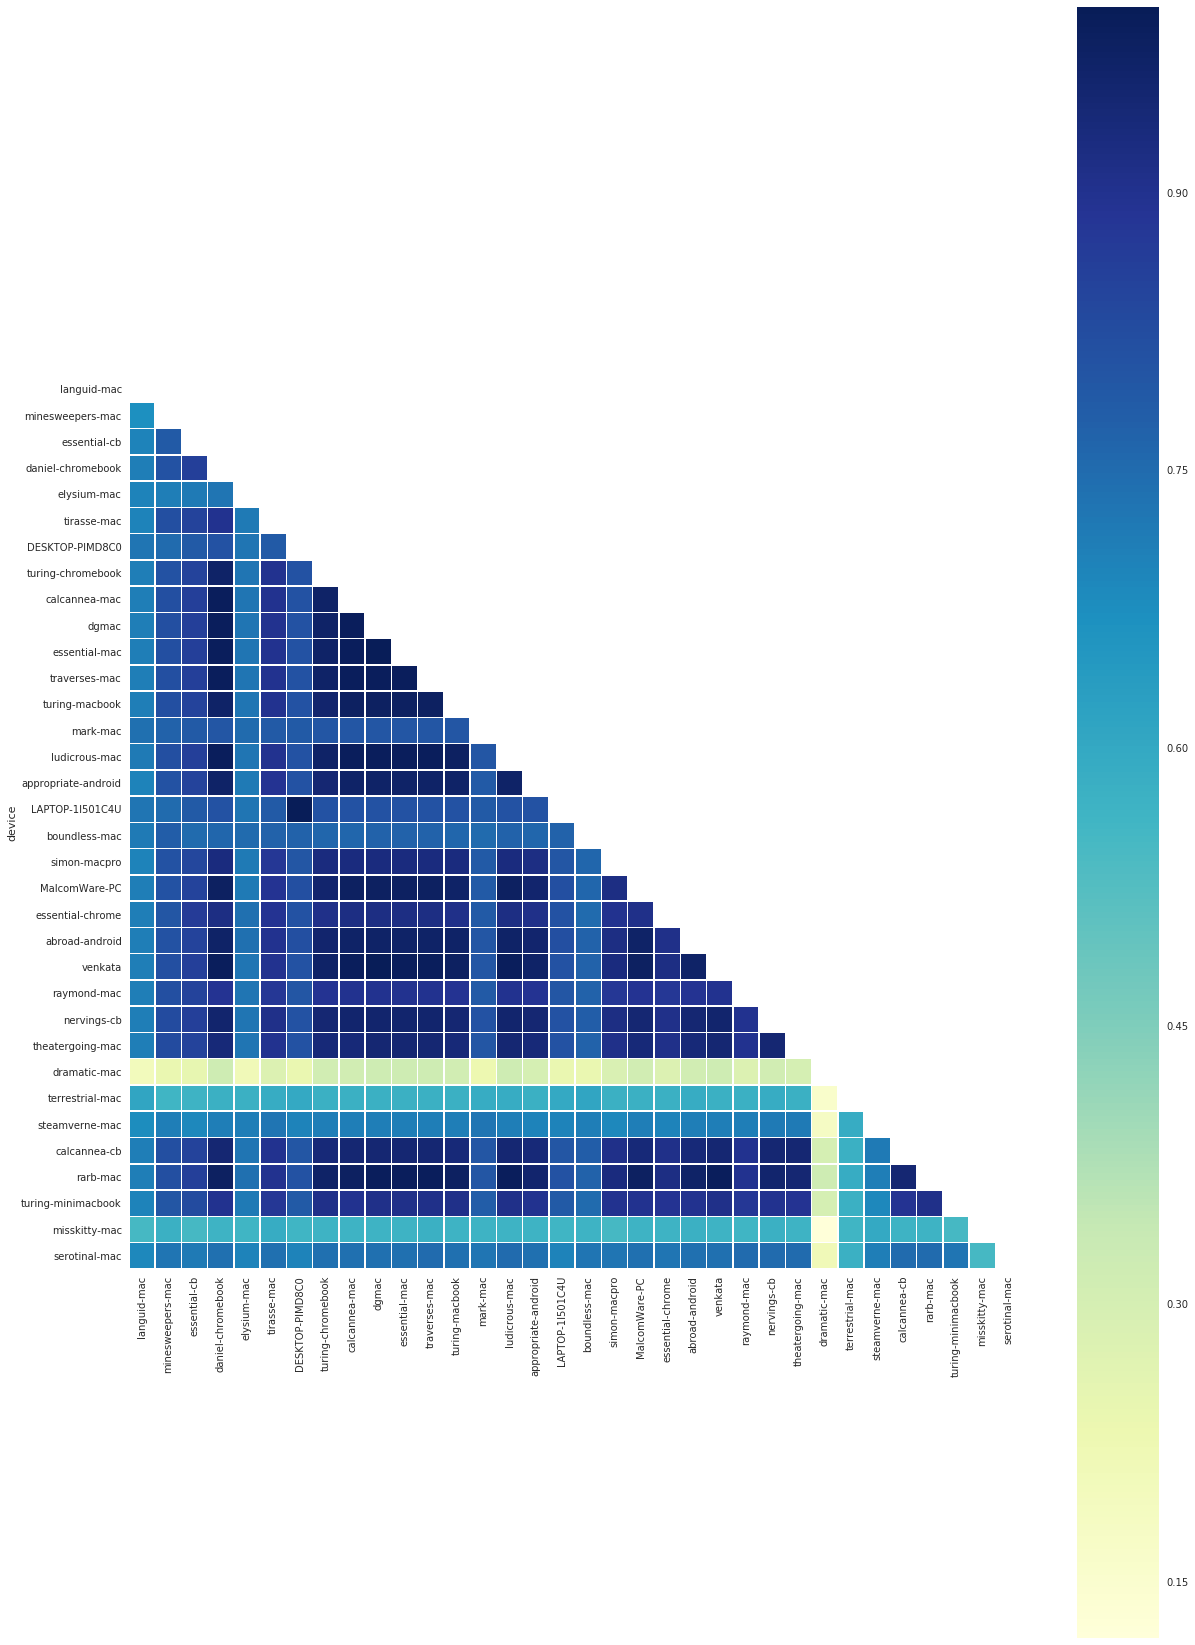

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Kendall Tau

In [18]:
# Calculate Rho on 2 lists
def correlator(a, b):

    n = max(len(a), len(b))
    
    alst = [v for v in range(0,len(a))]
    amap = {a[i]: i for i in range(0, len(a)) }
    blst = [amap[b[v]] if b[v] in amap else len(a) for v in range(0, len(b))]
    alst.extend([len(a)] * (n - len(a)))
    blst.extend([len(a)] * (n - len(b)))

    tau, p = stats.weightedtau(alst, blst)
  
    return tau

In [19]:
df3 = pd.DataFrame(fav_things, columns=["device", "servers"]).set_index("device")
for dev, servers in everyone:
    df3[dev] = df3["servers"].apply(lambda x: correlator(servers, x)).round(2)
df3

,servers,languid-mac,minesweepers-mac,essential-cb,daniel-chromebook,elysium-mac,tirasse-mac,DESKTOP-PIMD8C0,turing-chromebook,calcannea-mac,...,nervings-cb,theatergoing-mac,dramatic-mac,terrestrial-mac,steamverne-mac,calcannea-cb,rarb-mac,turing-minimacbook,misskitty-mac,serotinal-mac
device,,,,,,,,,,,,,,,,,,,,,
languid-mac,"[www.loopnet.com, ocsp.digicert.com, images2.l...",1.00,0.79,0.82,0.80,0.82,0.82,0.64,0.81,0.80,...,0.82,0.81,0.38,0.67,0.73,0.82,0.81,0.81,0.71,0.75
minesweepers-mac,"[eu-rseg-tts.inrix.com, cdn.clamxav.com, www.w...",0.79,1.00,0.77,0.87,0.77,0.91,0.65,0.88,0.87,...,0.89,0.87,0.42,0.70,0.81,0.89,0.88,0.88,0.73,0.83
essential-cb,"[www.gstatic.com, www.douglasadams.com, thedev...",0.82,0.77,1.00,0.87,0.83,0.85,0.70,0.89,0.87,...,0.88,0.83,0.46,0.70,0.75,0.83,0.88,0.90,0.61,0.80
daniel-chromebook,"[ecx.images-amazon.com, www.com, et1.getsideki...",0.80,0.87,0.87,1.00,0.80,0.92,0.71,0.97,0.99,...,0.95,0.95,0.41,0.73,0.81,0.96,0.99,0.91,0.70,0.79
elysium-mac,"[ocsp.digicert.com, www.blackrainbow.com, ocsp...",0.82,0.77,0.83,0.80,1.00,0.83,0.65,0.82,0.80,...,0.82,0.78,0.38,0.69,0.72,0.82,0.81,0.81,0.71,0.77
tirasse-mac,"[analytics.carambo.la, aldertons.com, www.cock...",0.82,0.91,0.85,0.92,0.83,1.00,0.70,0.92,0.92,...,0.93,0.92,0.35,0.75,0.82,0.94,0.93,0.92,0.73,0.81
DESKTOP-PIMD8C0,"[3.tlu.dl.delivery.mp.microsoft.com, 11.tlu.dl...",0.64,0.65,0.70,0.71,0.65,0.70,1.00,0.71,0.71,...,0.66,0.70,0.28,0.56,0.61,0.70,0.72,0.67,0.42,0.65
turing-chromebook,"[www.gstatic.com, mmcc.maryland.gov, ocsp.como...",0.81,0.88,0.89,0.97,0.82,0.92,0.71,1.00,0.97,...,0.88,0.93,0.46,0.74,0.81,0.97,0.98,0.91,0.69,0.79
calcannea-mac,"[m.bbc.co.uk, www.bbc.co.uk, nginx.org, www.gs...",0.80,0.87,0.87,0.99,0.80,0.92,0.71,0.97,1.00,...,0.95,0.95,0.42,0.74,0.81,0.96,0.99,0.91,0.70,0.78


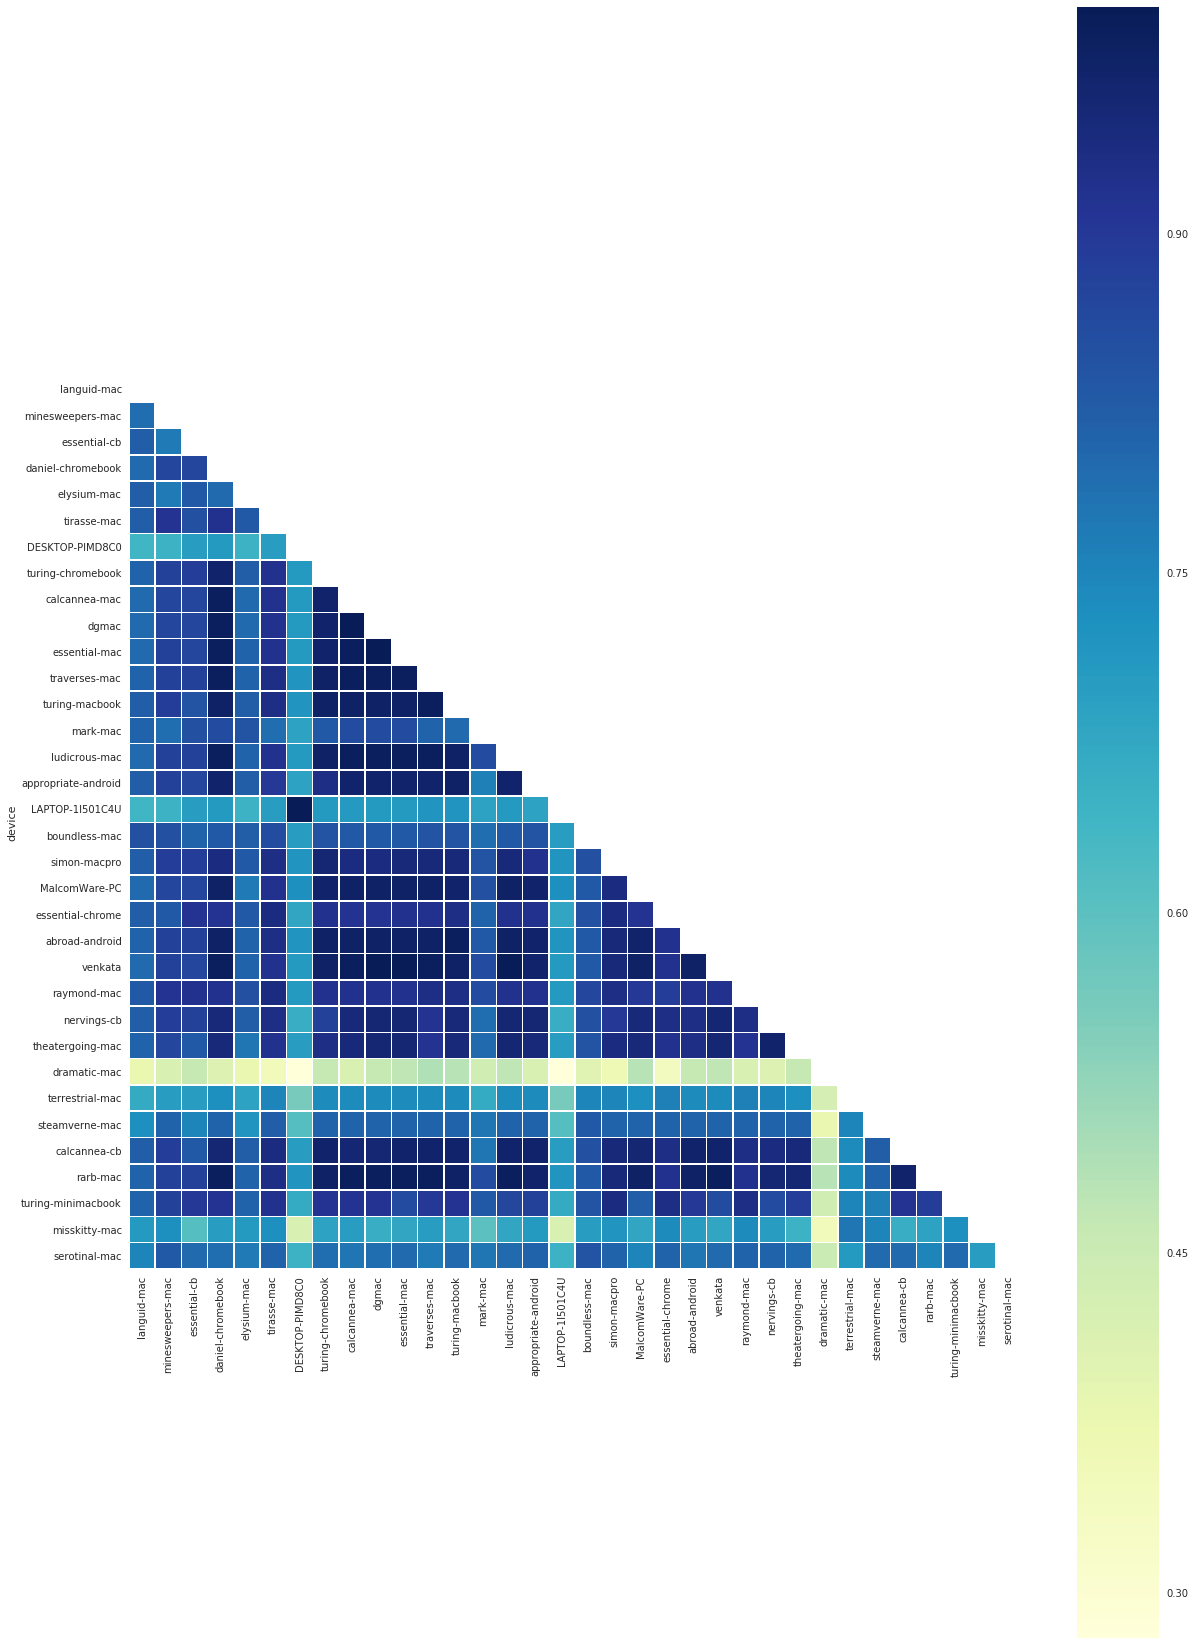

In [20]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()